In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('DATA FILE 334 (2).xlsx')  # Adjust the path to your file

# Ensure all column names are treated as strings (important if there are unnamed/numerical columns)
df.columns = df.columns.map(str)

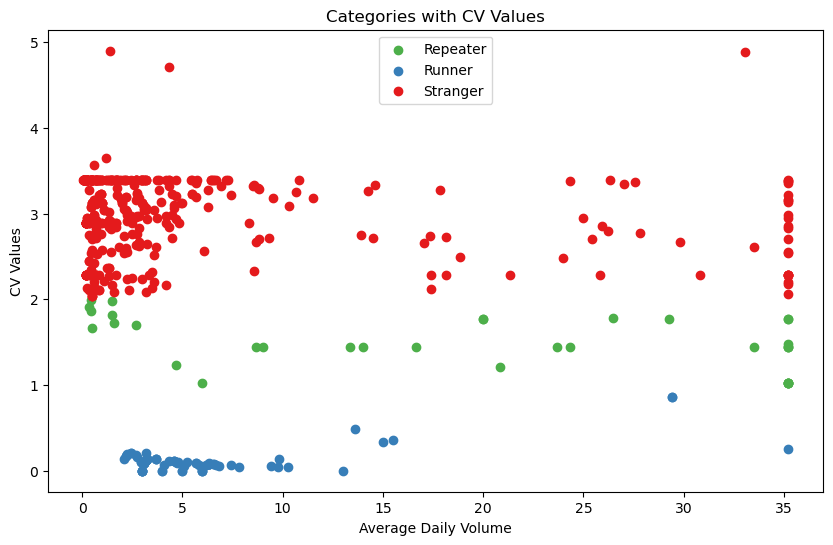

In [44]:


# List of columns that represent monthly demand data
# Adjust these column names to match your actual monthly demand columns
monthly_demand_columns = [col for col in df.columns if col.startswith('Jan') or col.startswith('Feb') or col.startswith('Mar') 
                          or col.startswith('Apr') or col.startswith('May') or col.startswith('Jun') 
                          or col.startswith('Jul') or col.startswith('Aug') or col.startswith('Sep') 
                          or col.startswith('Oct') or col.startswith('Nov') or col.startswith('Dec')]

df[monthly_demand_columns] = df[monthly_demand_columns].fillna(0)

# Calculate mean, standard deviation, and CV for each product across its monthly demand
df['mean_demand'] = df[monthly_demand_columns].mean(axis=1)
df['std_demand'] = df[monthly_demand_columns].std(axis=1)
df['cv_demand'] = df['std_demand'] / df['mean_demand']

# Count number of zeros in each row
df['zero_count'] = (df[monthly_demand_columns] == 0).sum(axis=1)

# Mark as 'Stranger' if more than 16 months of zeros
df['category'] = np.where(df['zero_count'] > 16, 'Stranger', '')

# Aggregate demand data to identify seasonal patterns
monthly_demand_means = df[monthly_demand_columns].mean()

# Calculate coefficient of variation (CV) for each month
monthly_demand_cv = df[monthly_demand_columns].std() / df[monthly_demand_columns].mean()

# Identify peak demand months
peak_demand_months = monthly_demand_means.nlargest(3).index.tolist()

# Define seasonality feature based on peak demand months
df['seasonality'] = np.where(df[peak_demand_months].sum(axis=1) > 0, 'Seasonal', 'Non-Seasonal')

# Adjust categorization logic to incorporate the 'seasonality' feature
# cv_low_threshold = df['cv_demand'].quantile(0.20)
# cv_high_threshold = df['cv_demand'].quantile(0.60)

cv_low_threshold = 1
cv_high_threshold = 2

conditions = [
    (df['cv_demand'] <= cv_low_threshold) & (df['seasonality'] == 'Seasonal'),
    (df['cv_demand'] > cv_low_threshold) & (df['cv_demand'] <= cv_high_threshold),
    (df['cv_demand'] > cv_high_threshold)
]
choices = ['Runner','Repeater', 'Stranger']
df['category'] = np.select(conditions, choices, default='Stranger')

# Capping cv_demand values at a certain threshold
cap_threshold = np.percentile(df['mean_demand'], 95)  # Example: cap at the 95th percentile
df['mean_demand_capped'] = df['mean_demand'].clip(upper=cap_threshold)

# Plotting
colors = {'Repeater': '#4daf4a',   # Green
          'Runner': '#377eb8',     # Blue
          'Stranger': '#e41a1c'}
plt.figure(figsize=(10, 6))
for category, group in df.groupby('category'):
    plt.scatter(group['mean_demand_capped'], group['cv_demand'], label=category, color=colors[category])

plt.xlabel('Average Daily Volume')
plt.ylabel('CV Values')
plt.title('Categories with CV Values')
plt.legend()
plt.show()



In [45]:
value_counts = df['category'].value_counts()

print(value_counts)

Stranger    576
Runner       79
Repeater     34
Name: category, dtype: int64


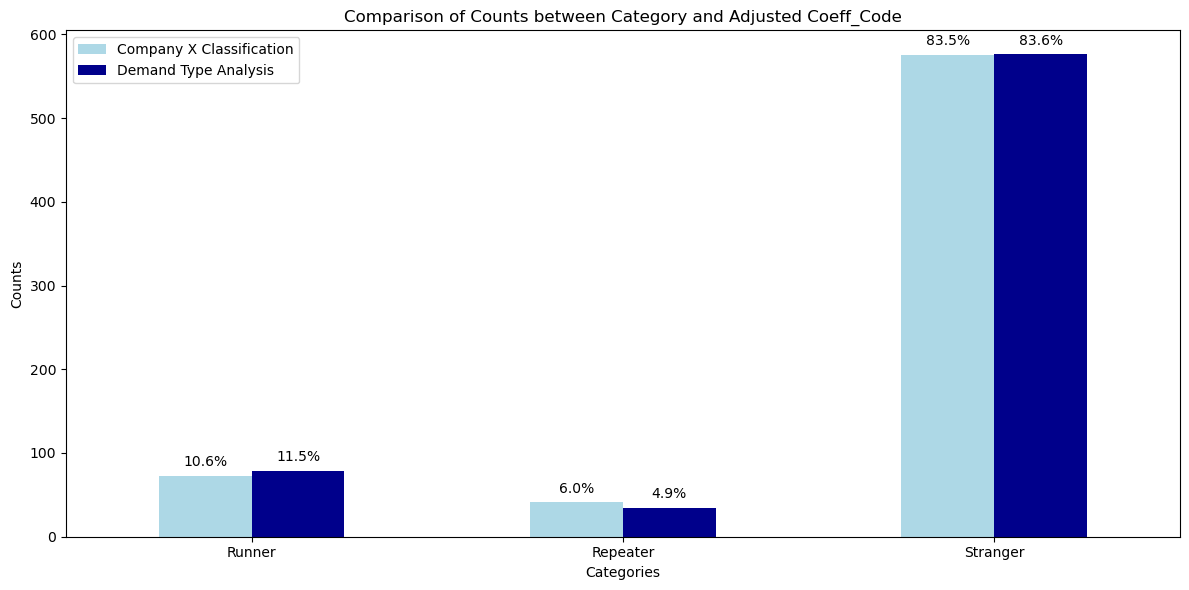

In [46]:

# Replace 'Spiker' with 'Stranger' in the 'Coeff_Code' column
df['Coeff_Code'] = df['Coeff_Code'].replace('Spiker', 'Stranger')

# Calculate the count of each unique value in the 'category' column
category_counts = df['category'].value_counts().reindex(['Runner', 'Repeater', 'Stranger'], fill_value=0)

# Calculate the count of each unique value in the 'Coeff_Code' column
coeff_code_counts = df['Coeff_Code'].value_counts().reindex(['Runner', 'Repeater', 'Stranger'], fill_value=0)

# Creating a new DataFrame from the counts for comparison
counts_df = pd.DataFrame({
    'Company X Classification': coeff_code_counts,
    'Demand Type Analysis': category_counts
})

# Plotting the counts
ax = counts_df.plot(kind='bar', figsize=(12, 6), color=['#ADD8E6', '#00008B'])

# Calculate the percentage of each bar
total = counts_df['Demand Type Analysis'].sum()
percentages = counts_df / total * 100

# Annotate the bars with percentage values
for i in ax.patches:
    # Get the height of the bar
    h = i.get_height()
    # If height is zero (i.e., bar isn't visible), we don't annotate
    if h > 0:
        ax.annotate(f'{h/total*100:.1f}%', 
                    (i.get_x() + i.get_width() / 2., h), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Comparison of Counts between Category and Adjusted Coeff_Code')
plt.ylabel('Counts')
plt.xlabel('Categories')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()

plt.show()


